In [2]:
from __future__ import unicode_literals, division
from io import open
import glob
import os

In [3]:
def findFiles(path):
    return glob.glob(path)

In [4]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [5]:
import unicodedata
import string

In [15]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

57


In [7]:
def unicodeToAscii(s):
    return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in all_leters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [21]:
category_lines = {}
all_categories = []

In [22]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
print(n_categories)

18


In [14]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [16]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [23]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [24]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [28]:
input= lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8377, -2.9052, -2.9519, -2.8737, -2.9480, -2.8344, -3.0272, -2.8762,
         -2.9309, -2.8514, -2.8404, -3.0328, -2.9016, -2.8199, -2.9177, -2.8171,
         -2.8866, -2.8112]], grad_fn=<LogSoftmaxBackward>)


In [34]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 17)


In [35]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line = ', line)

category =  German / line =  Fertig
category =  Polish / line =  Sniegowski
category =  Spanish / line =  Gomez
category =  Japanese / line =  Hyobanshi
category =  Czech / line =  Cihak
category =  Chinese / line =  Sui
category =  Irish / line =  Maguire
category =  Polish / line =  Wiater
category =  Chinese / line =  Siew
category =  Scottish / line =  Aitken


In [36]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [38]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(i, n_iters + 1):
    category, line,category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
    

5000 5% (0m 8s) 2.4048 Kikui / Italian ✗ (Japanese)
10000 10% (0m 17s) 2.3834 Vargas / Arabic ✗ (Portuguese)
15000 15% (0m 26s) 1.9547 Souza / Czech ✗ (Portuguese)
20000 20% (0m 36s) 0.2936 Kawamura / Japanese ✓
25000 25% (0m 45s) 2.2191 Widdows / Dutch ✗ (English)
30000 30% (0m 55s) 0.2074 Dertilis / Greek ✓
35000 35% (1m 3s) 2.4550 Steinborn / Dutch ✗ (Czech)
40000 40% (1m 13s) 2.4435 Han / Chinese ✗ (Korean)
45000 45% (1m 22s) 1.0985 Whyte / Scottish ✓
50000 50% (1m 31s) 0.7236 Phung / Vietnamese ✓
55000 55% (1m 39s) 0.5009 Buiren / Dutch ✓
60000 60% (1m 48s) 2.3940 Silje / Scottish ✗ (Dutch)
65000 65% (1m 57s) 0.0410 Cherpakov / Russian ✓
70000 70% (2m 6s) 0.5691 Lac / Vietnamese ✓
75000 75% (2m 15s) 3.5401 Raskob / Russian ✗ (German)
80000 80% (2m 23s) 3.1798 Amantea / Spanish ✗ (Italian)
85000 85% (2m 32s) 0.2583 Koolen / Dutch ✓
90000 90% (2m 41s) 1.1954 Sarno / Portuguese ✗ (Italian)
95000 95% (2m 50s) 0.0042 Desyatkov / Russian ✓
100000 100% (2m 59s) 1.7956 Aller / German ✗ (D

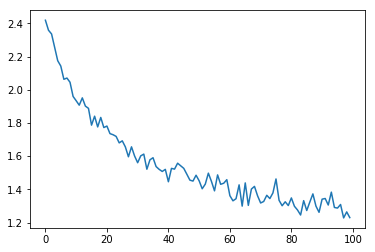

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

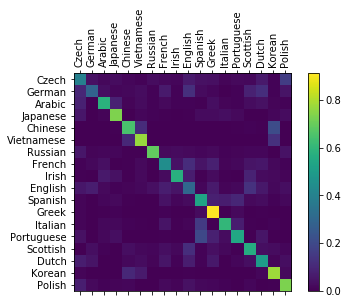

In [41]:
#confusion_matrix

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()